In [1]:
%matplotlib inline

import logging
logging.getLogger('tensorflow').disabled = True

import time
import sys
sys.path.append("../../TransportNets")

import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import tensorflow as tf
import tensorflow_probability as tfp

from Models.NVP import NVP
from Probability.Distributions import RotatedBanana

tfd = tfp.distributions
tfb = tfp.bijectors

## Train the Normalizing Flow
First, we train the flow to map a double moon distribution to a guassian. The end goal is to perform conditional sampling using MCMC along a part of the distribution where we cross 4 different 'modes'. 

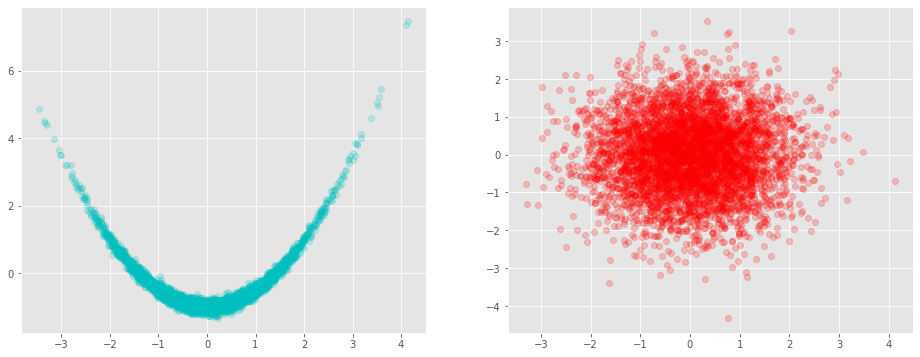

In [2]:
# Distrubtion that we want to learn to map to gaussian 
num_samples = 5000

target = RotatedBanana(num_samples, 0.0, start_height = -1)
latent = tf.random.normal([num_samples,2],mean=0.0,stddev=1.0)

# Plot them
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(121); ax2 = plt.subplot(122);
ax1.plot(target[:,0], target[:,1], 'co', alpha = .2)
ax2.plot(latent[:,0], latent[:,1], 'ro', alpha = .2)

In [3]:
# Create model object
nvp = NVP(num_layers=4, neuron_list=[200,200])

# Create optimizer and compile nvp with it
opt = tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-06)
nvp.compile(opt)

# Perform a forward pass to initialize variables
_ = nvp(latent)

In [5]:
# Define training options
n_epochs = 100
batch_size = 50

# Put the target data in a format the tf likes.
dataset = tf.data.Dataset.from_tensor_slices(target)
dataset = dataset.shuffle(buffer_size=5000).batch(batch_size)

# Train the model with the new callback
nvp.batch_norm_mode(True)
history = nvp.fit(dataset, epochs=n_epochs)  # Pass callback to training

# Set the training variables to not update when doing passes
nvp.batch_norm_mode(False)

Epoch 1/100
100/100 [==============================] - 2s 20ms/step - Negative Log Likelihood: 1.7161
Epoch 2/100
100/100 [==============================] - 2s 19ms/step - Negative Log Likelihood: 1.5524
Epoch 3/100
100/100 [==============================] - 2s 19ms/step - Negative Log Likelihood: 1.4172
Epoch 4/100
100/100 [==============================] - 2s 20ms/step - Negative Log Likelihood: 1.2979
Epoch 5/100
100/100 [==============================] - 2s 20ms/step - Negative Log Likelihood: 1.2292
Epoch 6/100
100/100 [==============================] - 2s 20ms/step - Negative Log Likelihood: 1.1608
Epoch 7/100
100/100 [==============================] - 2s 20ms/step - Negative Log Likelihood: 1.1091
Epoch 8/100
100/100 [==============================] - 2s 20ms/step - Negative Log Likelihood: 1.0680
Epoch 9/100
100/100 [==============================] - 2s 19ms/step - Negative Log Likelihood: 1.0235
Epoch 10/100
100/100 [==============================] - 2s 19ms/step - Negative Lo

100/100 [==============================] - 2s 19ms/step - Negative Log Likelihood: 0.6386
Epoch 81/100
100/100 [==============================] - 2s 19ms/step - Negative Log Likelihood: 0.6429
Epoch 82/100
100/100 [==============================] - 2s 19ms/step - Negative Log Likelihood: 0.6323
Epoch 83/100
100/100 [==============================] - 2s 19ms/step - Negative Log Likelihood: 0.6381
Epoch 84/100
100/100 [==============================] - 2s 19ms/step - Negative Log Likelihood: 0.6380
Epoch 85/100
100/100 [==============================] - 2s 19ms/step - Negative Log Likelihood: 0.6341
Epoch 86/100
100/100 [==============================] - 2s 20ms/step - Negative Log Likelihood: 0.6324
Epoch 87/100
100/100 [==============================] - 2s 20ms/step - Negative Log Likelihood: 0.6335
Epoch 88/100
100/100 [==============================] - 2s 20ms/step - Negative Log Likelihood: 0.6248
Epoch 89/100
100/100 [==============================] - 2s 20ms/step - Negative Log Li

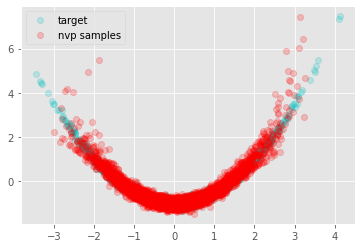

In [10]:
# Plot to make sure it worked
forward_pass = nvp(tf.random.normal([num_samples,2],mean=0.0,stddev=1.0))
plt.plot(target[:,0], target[:,1], 'co', alpha = .2,label='target')
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2,label='nvp samples')
plt.legend()

## Conditional Sampling using Metropolis Hastings

Text(0, 0.5, 'predictions')

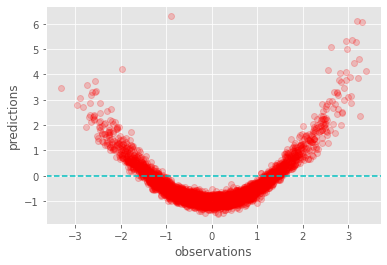

In [12]:
# We want to draw condition samples from about y = 0.0
y_star = 0.0

forward_pass = nvp(tf.random.normal([5000,2],mean=0.0,stddev=1.0))
plt.plot(forward_pass[:, 0], forward_pass[:, 1], 'ro', alpha=.2)
plt.axhline(y=y_star, color='c', linestyle='--')
plt.xlabel('observations')
plt.ylabel('predictions')

In [13]:
# First, we define the function that gives the log prob at a point
def log_c_target(x1, x2 = y_star):
    x = tf.constant([x1,x2],shape=[1,2])
    #log of probability density at that point
    return nvp.log_prob(x)

# Next, the Metropolis hastings algorithm
def MCMC(niters=3000,b=2,init_val=0.0):
    # niters: number of interations of MCMC
    # b: variance of the proposal Gaussian density for X1
    
    naccept=0
    theta = init_val # initial value for the Markov chain

    samples = np.zeros(niters+1)
    samples[0] = theta
    t0 = time.time()
    for i in range(niters):
        theta_p = theta + np.random.randn()*b;
        rho = min(1, tf.math.exp(log_c_target(theta_p)-log_c_target(theta)))
        u = np.random.uniform()
        if u < rho:
            naccept += 1
            theta = theta_p
        samples[i+1] = theta
        if i % 100 == 0:
            t1 = time.time()
            print('it:',i,'time:',t1-t0)
            t0 = t1
    acceptance_rate = naccept/niters
    
    return acceptance_rate, samples

In [14]:
# Run the algorithm
acc_rate, samples = MCMC()

it: 0 time: 0.674778938293457
it: 100 time: 0.9826145172119141
it: 200 time: 0.9812026023864746
it: 300 time: 0.9916033744812012
it: 400 time: 0.9776380062103271
it: 500 time: 0.9599518775939941
it: 600 time: 0.9643681049346924
it: 700 time: 0.9847707748413086
it: 800 time: 0.9851460456848145
it: 900 time: 0.9601790904998779
it: 1000 time: 0.9554116725921631
it: 1100 time: 1.0057387351989746
it: 1200 time: 1.0022168159484863
it: 1300 time: 0.9445464611053467
it: 1400 time: 0.9476630687713623
it: 1500 time: 0.9938333034515381
it: 1600 time: 0.9974730014801025
it: 1700 time: 0.9285809993743896
it: 1800 time: 0.9230351448059082
it: 1900 time: 0.9444963932037354
it: 2000 time: 0.9799098968505859
it: 2100 time: 0.931086540222168
it: 2200 time: 0.9504594802856445
it: 2300 time: 0.9450826644897461
it: 2400 time: 0.9543483257293701
it: 2500 time: 0.9770200252532959
it: 2600 time: 0.9075229167938232
it: 2700 time: 0.9774091243743896
it: 2800 time: 0.9385504722595215
it: 2900 time: 0.94233703613

[(-3.0, 3.0)]

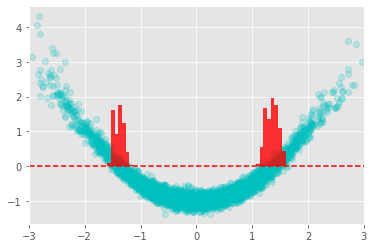

In [9]:
fig, ax = plt.subplots()
ax.plot(forward_pass[:, 0], forward_pass[:, 1], 'co', alpha=.2)
ax.hist(samples, 150, (-5, 5), color='r', alpha=.8, density=True, zorder=10)
ax.axhline(y=y_star, color='r', linestyle='--')
ax.set(xlim=(-3, 3))

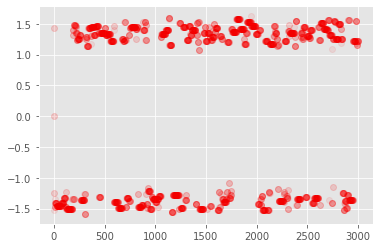

In [10]:
plt.plot(samples, 'ro', alpha = .075)